# Implementing Logistic Regression

In [6]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

## Abstract

For this blog post I implemented the perceptron algorithm. I then ran several experiments to visualize the changes to my model each iteration and see the improvement of my loss. I investigated how the perceptron implementation changed when given linearly separable data vs not and 2 dimension vs more dimensional data. I also implemented mini-batch and ran experiments to see how this impacted algorithm outcomes. Through these steps, I learned the perceptron algorithm works and how that functionality can change to accommodate different data. Ultimately, I learned that the perceptron algorithm works well to address many different data forms by continuously updating the model based on misclassified points.

Link to source code ([logistic.py]())

## Experiments

Before doing any experiments, I had to generate data for a classification problem.

In [65]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

Plot the data

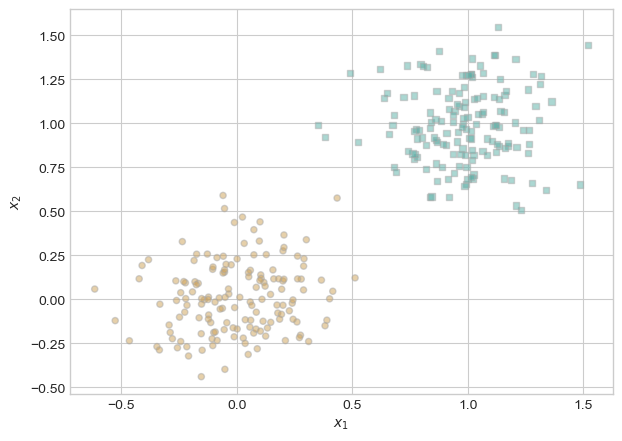

In [66]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
    
fig, ax = plt.subplots(1, 1)

# p_dims is 2
X, y = classification_data(noise = 0.2)
# print(f"{X=}")
# print(f"{y=}")
plot_classification_data(X, y, ax)

Code tp graph a straight line

In [67]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

### Vanilla Gradient Descent

The first experiment that I performed was vanilla gradient descent: When p_dim = 2, when alpha is sufficiently small and beta=0.

Want to see:

1. Gradient descent for logistic regression converges to a weight vector w that looks visually correct
    * show this by plot the decision boundary with the data
2. Loss decreases monotonically: A monotonic function is a function which is either entirely nonincreasing or nondecreasing.
    * show this by plotting the loss over iterations

First implement a training loop with graphs with a dividing line to visualize our progress.

IndexError: index 6 is out of bounds for axis 0 with size 6

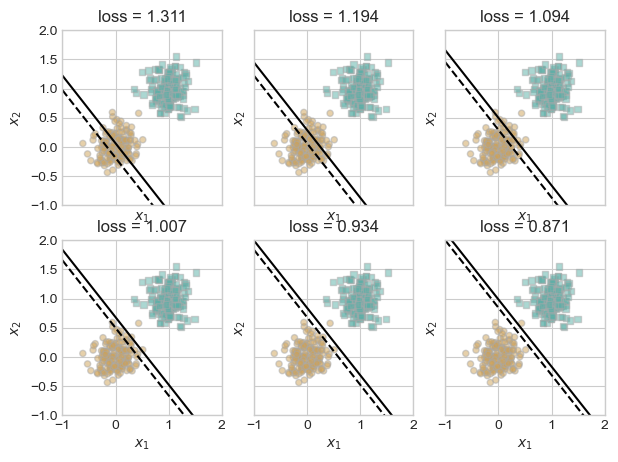

In [68]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
loss = LR.loss(X,y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss_vec = []

for index in range(0,1000):
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(LR.w)

    # for vanilla gradient descent, alpha must be sufficiently small and beta must be 0
    local_loss = opt.step(X, y, alpha = 0.3, beta = 0)
    
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if (local_loss > 0):
                
        if(current_ax < 6):
            # Plot and record loss for the first 6 changes
            plot_classification_data(X, y, ax)
            draw_line(old_w, x_min=-1, x_max=2, ax=ax, color="black", linestyle="dashed")
            
            loss = LR.loss(X, y).item()
            # print(f"{loss=}")
            
            loss_vec.append(loss)
            draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
            ax.set_title(f"loss = {loss:.3f}")
            ax.set(xlim=(-1, 2), ylim=(-1, 2))
            current_ax += 1
        else:
            # after the first 6 updates, just calculate and record loss
            loss = LR.loss(X, y).item()
            loss_vec.append(loss)
            
plt.tight_layout()

We can see here in the training loop, that the dividing line, determined by our logistic regression weights is slowly becoming a better dividing line for our data.

Plot the loss over time, only showing when the loss is updated

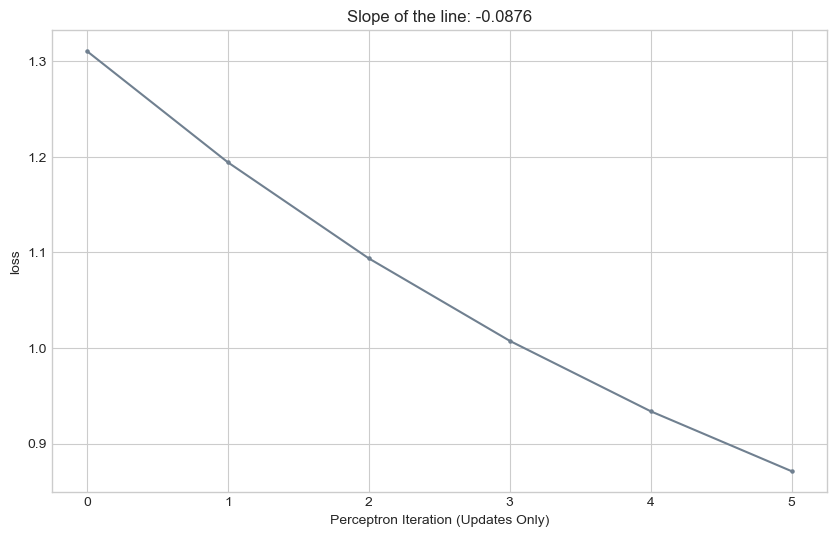

In [69]:
import numpy as np

def plot_loss(loss):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    
    plt.plot(loss, color = "slategrey")
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

    # Calculate the slope of the line
    x = np.arange(len(loss))
    slope, _ = np.polyfit(x, loss, 1)
    
    # Add the slope to the title
    plt.title(f"Slope of the line: {slope:.4f}")

plot_loss(loss_vec)

We can see that the loss is decreasing monotonically over time through this graph of the loss. The negative slope shows us that the loss is in fact decreasing over time. In other words, our machine learning model is learning!

Plot the final line separating the data

[(-1.0, 2.0), (-1.0, 2.0)]

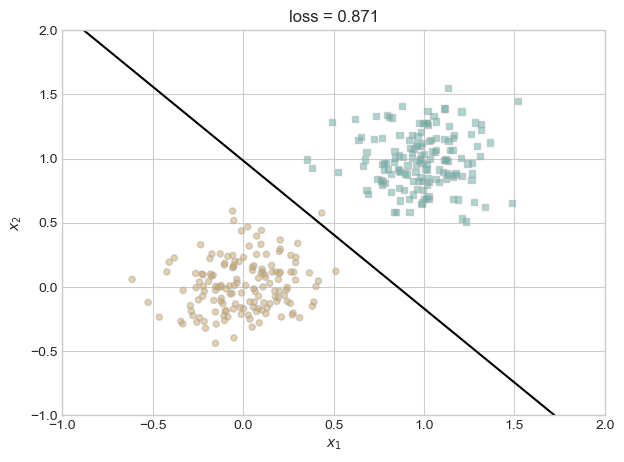

In [70]:
fig, ax = plt.subplots(1, 1)

plot_classification_data(X, y, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-1, 2), ylim=(-1, 2))

We can see that the dividing line almost perfectly divides the classes. In time, we could see the logistic regression training could become perfectly accurate.

## Benefits of momentum

Our next experiment was to see the benefits of momentum. On the same data, gradient descent with momentum (e.g. beta=0.9) can converge to the correct weight vector in fewer iterations than vanilla gradient descent (with beta=0).

We want to see: 

1. A model that learns at a faster rate
    * show loss decreasing at a faster rate than when beta was 0

First implement a training loop with graphs with a dividing line to visualize our progress.

IndexError: index 6 is out of bounds for axis 0 with size 6

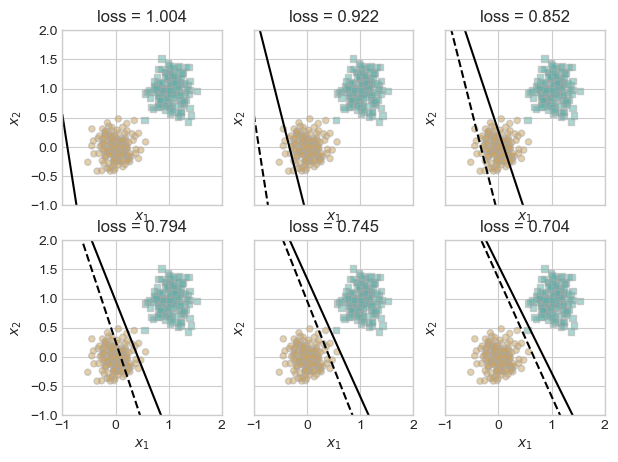

In [71]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)
X, y = classification_data(noise = 0.2)
LR.loss(X,y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss_vec = []

for index in range(0,1000):
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(LR.w)

    # to see the benefits of momentum, alpha must be sufficiently small and beta must be 0.9
    local_loss = opt.step(X, y, alpha = 0.3, beta = 0.9)
    
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if (local_loss > 0):
                
        if(current_ax < 6):
            # Plot and record loss for the first 6 changes
            plot_classification_data(X, y, ax)
            draw_line(old_w, x_min=-1, x_max=2, ax=ax, color="black", linestyle="dashed")
            
            loss = LR.loss(X, y).item()            
            loss_vec.append(loss)
            
            draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
            ax.set_title(f"loss = {loss:.3f}")
            ax.set(xlim=(-1, 2), ylim=(-1, 2))
            current_ax += 1
        else:
            # after the first 6 updates, just calculate and record loss

            loss = LR.loss(X, y).item()            
            loss_vec.append(loss)
plt.tight_layout()

We can see here in the training loop, that the dividing line, determined by our logistic regression weights is slowly becoming a better dividing line for our data. We still do not know if the beta increase made a significant difference in our model's learning rate.

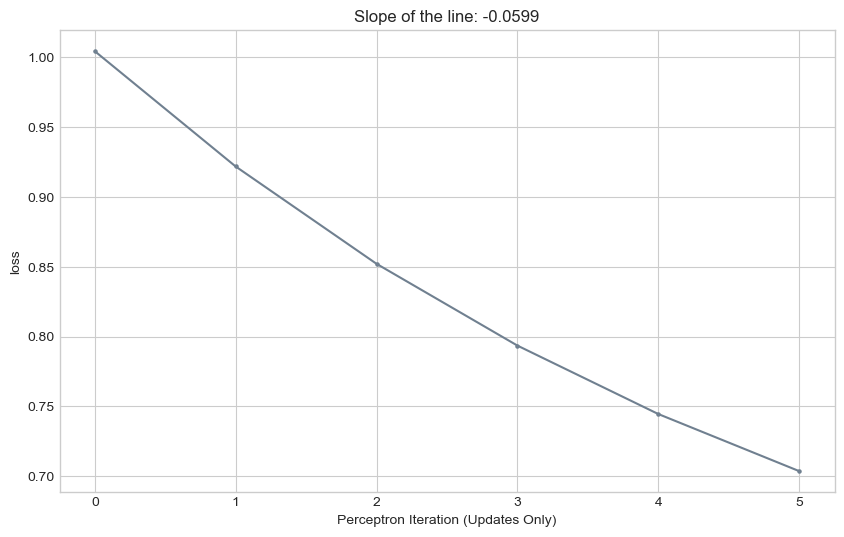

In [72]:
plot_loss(loss_vec)

The faster declining slope of the loss shows that the later beta value does in fact increase the learning speed of the machine learning model.

[(-1.0, 2.0), (-1.0, 2.0)]

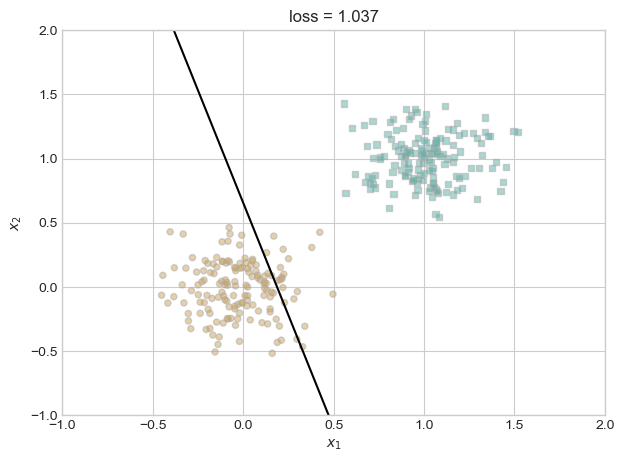

In [12]:
fig, ax = plt.subplots(1, 1)

plot_classification_data(X, y, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-1, 2), ylim=(-1, 2))

We can see the benefits of increase of momentum by viewing the improved dividing line. The increase in the beta value allows our logistic regression to improve at a much faster rate then when beta=0. We know that because with the same number of iterations, the loss decreased more, or in other words, the model learned to classify at a faster rate.

## Overfitting

Our final experiment was to show the danger of overfitting. To show this I need to generate some data where p_dim > n_points and create an instance where the same logistic regression model has a 100% accuracy rate on training data.

Want to see:

1. Perfect accuracy for training data
2. Less accurate classification for testing data with the exact same parameters

For overfitting, we need to generate data where p_dim > n_points.

In [100]:
X_train, y_train = classification_data(n_points = 50, noise = 0.2, p_dims = 100)

Goal to achieve 100% accuracy with the training data.

In [101]:
# initialize a Logistic Regression 
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize for main loop
loss_vec = []

for index in range(0, 1000):
    # Calculate and record loss
    loss = LR.loss(X_train, y_train).item()
    loss_vec.append(loss)

    # to see the benefits of momentum, alpha must be sufficiently small and beta must be 0.9
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9)
    print(f"{loss=}")
            
plt.tight_layout()

loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
loss=nan
l

<Figure size 700x500 with 0 Axes>

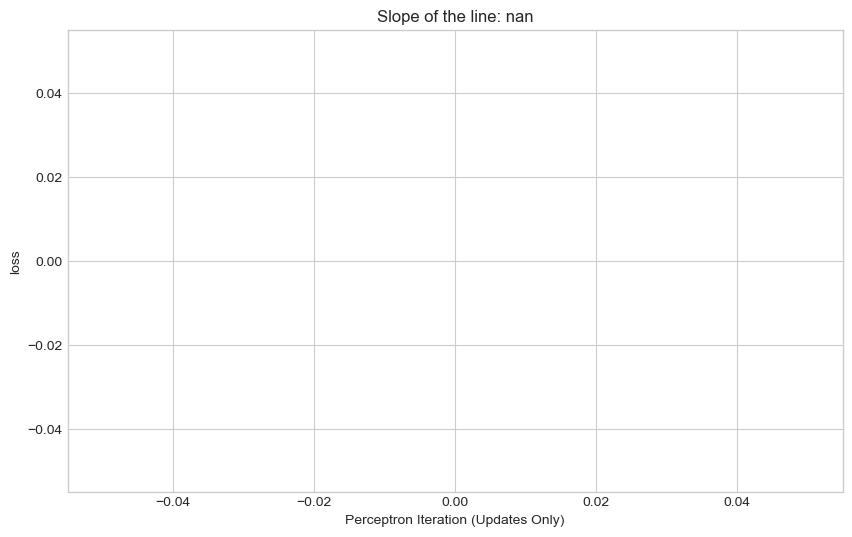

In [102]:
plot_loss(loss_vec)

We can see the model reaching a point when loss = 0, in other words, when the model has 100% accuracy for the training data.

Check the accuracy of the Logistic Regression function on the training data.

[(-1.0, 2.0), (-1.0, 2.0)]

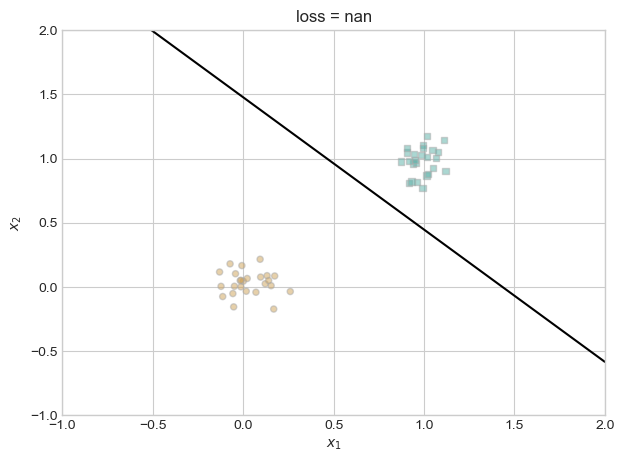

In [95]:
fig, ax = plt.subplots(1, 1)

plot_classification_data(X_train, y_train, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss}")
ax.set(xlim=(-1, 2), ylim=(-1, 2))

Here again we see how the logistic regression model has been fit perfectly to the training data.

Then we must initialize the test data with the same parameters as the training data.

In [96]:
X_test, y_test = classification_data(n_points = 50, noise = 0.2, p_dims = 100)

[(-1.0, 2.0), (-1.0, 2.0)]

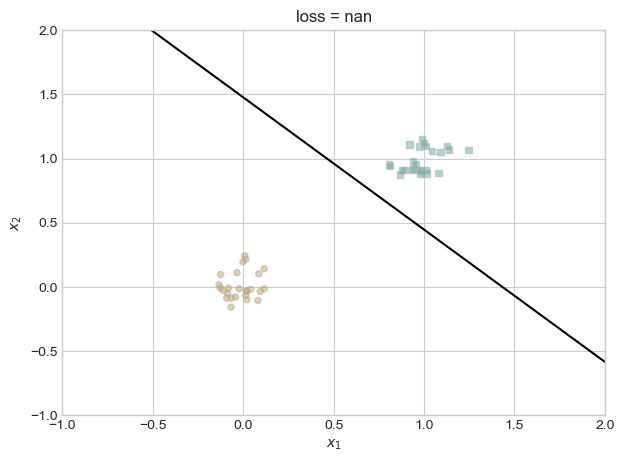

In [97]:
fig, ax = plt.subplots(1, 1)

plot_classification_data(X_test, y_test, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
# CHANGE TITLE
ax.set_title(f"loss = {loss}")
ax.set(xlim=(-1, 2), ylim=(-1, 2))

We can see that the logistic regression model has overfit to the training data and cannot classify the test data with nearly the same accuracy. This it the danger of fitting a model too well to training data, it is now not generalizable to other data.

## Conclusion

For this blog post I implemented the perceptron algorithm. I then ran several experiments to visualize the changes to my model each iteration and see the improvement of my loss. I investigated how the perceptron implementation changed when given linearly separable data vs not and 2 dimension vs more dimensional data. I also implemented mini-batch and ran experiments to see how this impacted algorithm outcomes. Through these steps, I learned the perceptron algorithm works and how that functionality can change to accommodate different data. Ultimately, I learned that the perceptron algorithm works well to address many different data forms by continuously updating the model based on misclassified points.

Link to source code ([perceptron.py](https://github.com/lfschweitzer/lfschweitzer.github.io/blob/8cd58f0ce43ca46d3514b1edf017020f1b33a4bc/posts/post4/perceptron.py)) and ([perceptron_minibatch.py](https://github.com/lfschweitzer/lfschweitzer.github.io/blob/13b74a5d65a3e0d421726048a0a7a9a19235fbba/posts/post4/perceptron_minibatch.py))